In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
#hawaii.sqlite file path
hawaii_path = Path(r'C:\Users\kylem\Desktop\Bootcamp_Assignments\Challenges\Challenge_10\sqlalchemy-challenge\Resources\hawaii.sqlite')
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{hawaii_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#Finding details of the Measurement table
mc = inspect(engine).get_columns('measurement')
for c in mc:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Finding details of the Staion table
sc = inspect(engine).get_columns('station')
for c in sc:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdate = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydate = dt.date(lastdate.year -1, lastdate.month, lastdate.day)
print(lastdate,querydate)


2017-08-23 00:00:00 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
result = session.query(*sel).\
    filter(measurement.date >= querydate).all()

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(result, columns=['Date','Precipitation'])
precipitation = precipitation.sort_values(['Date'], ascending=True)

# Sort the dataframe by date
precipitation = precipitation.set_index('Date')
precipitation = precipitation.reset_index()
precipitation = precipitation.dropna()
precipitation.head()

,Date,Precipitation
0,2016-08-23,0.00
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15
5,2016-08-23,0.70


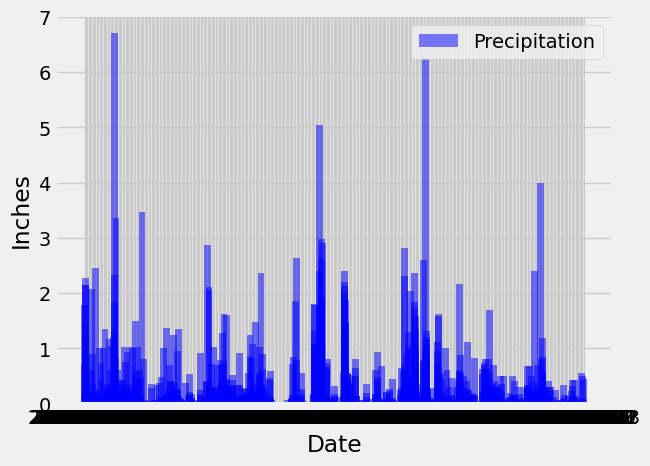

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1, ax1 = plt.subplots()

ax1.bar(precipitation['Date'],precipitation['Precipitation'], width=5, alpha = 0.5, color='b',label = 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.show()


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.name)).all()

[(9,)]

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
sel1 = [measurement.station, func.count(measurement.id)]

# List the stations and their counts in descending order.
active = session.query(*sel1).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
#Query to find the most active station
most_active_station = session.query(*sel1).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station

('USC00519281', 2772)

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel2 = [func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)]
most_active_temps = session.query(*sel2).\
    filter(measurement.station == 'USC00519281')
for x in most_active_temps:
    print(x)
    


(54.0, 85.0, 71.66378066378067)


In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel3 = [measurement.date, measurement.tobs]
station_temp = session.query(*sel3).\
    filter(measurement.station== 'USC00519281',measurement.date >= querydate).\
    order_by(measurement.date).all()
station = pd.DataFrame(station_temp, columns= ['Date', 'Temp'])
station.head()



,Date,Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


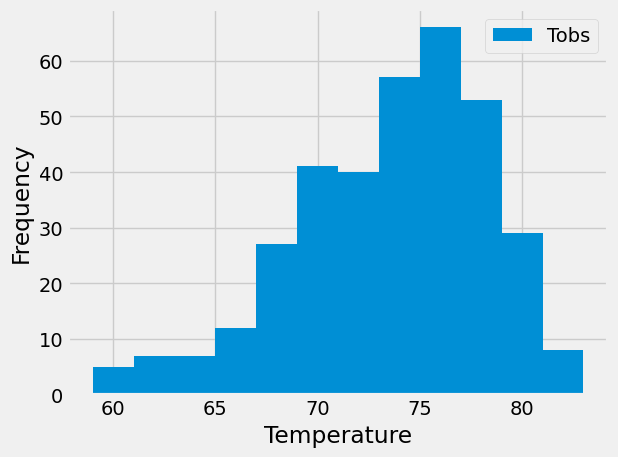

In [31]:
plt.hist(station['Temp'], bins =12,label = 'Tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.legend()
plt.show()

# Close Session

In [32]:
# Close Session
session.close()